In [74]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os


In [82]:
#ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
ROOT_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(ROOT_DIR, "data", "raw")
MODEL_DIR = os.path.join(ROOT_DIR, "models")
os.makedirs(DATA_DIR, exist_ok=True)

In [81]:
path = os.path.join(DATA_DIR, "arxiv_2025-07-04_200.csv")
df = pd.read_csv(path)

In [30]:
main_map = {
    "physics": "general_physics",
    "cond-mat": "condensed_matter_quant",
    "astro-ph": "astro_particle",
    "gr-qc": "astro_particle",
    "hep-ex": "astro_particle",
    "hep-ph": "astro_particle",
    "hep-th": "astro_particle",
    "hep-lat": "astro_particle",
    "nucl-ex": "astro_particle",
    "nucl-th": "astro_particle",
    "quant-ph": "condensed_matter_quant",

}

In [49]:
sub_map = {
    "optics": "optics",
    "flu-dyn": "fluid",
    "chem-ph": "other",

}


In [50]:
def split_category(cat):
    parts = cat.split('.')
    main_cat = parts[0]
    sub_cat = parts[1] if len(parts) > 1 else None
    return main_cat, sub_cat

In [54]:
def categorize(cat):
    main_cat, sub_cat = split_category(cat)
    if main_cat == "physics" and sub_cat in sub_map:
        return sub_map[sub_cat]
    else:
        return main_map.get(main_cat, "other")

In [55]:
df["broad_category"] = df["primary_category"].apply(categorize)

<Axes: xlabel='broad_category'>

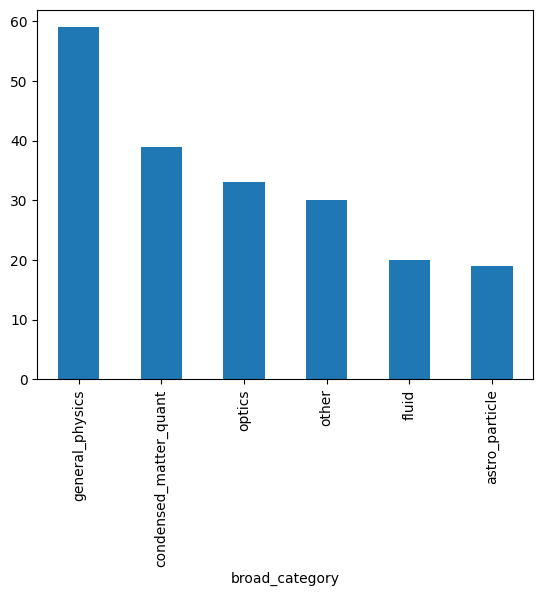

In [57]:
df['broad_category'].value_counts().plot(kind='bar')

In [23]:
df['primary_category'].value_counts()

primary_category
physics.optics        33
physics.flu-dyn       20
quant-ph              15
physics.chem-ph       13
physics.soc-ph        10
cond-mat.mtrl-sci      8
physics.plasm-ph       8
physics.ins-det        8
cond-mat.soft          7
physics.app-ph         7
physics.atom-ph        6
cs.LG                  5
astro-ph.EP            4
astro-ph.SR            3
physics.class-ph       3
cond-mat.mes-hall      3
physics.space-ph       3
physics.bio-ph         3
q-bio.PE               3
cond-mat.stat-mech     2
astro-ph.HE            2
physics.ed-ph          2
hep-ph                 2
physics.geo-ph         2
cond-mat.supr-con      2
astro-ph.GA            2
physics.acc-ph         2
cond-mat.quant-gas     2
physics.comp-ph        2
astro-ph.IM            2
physics.ao-ph          2
astro-ph.CO            1
gr-qc                  1
hep-ex                 1
cs.AI                  1
eess.IV                1
q-fin.PM               1
nlin.AO                1
cs.DL                  1
physics.

In [58]:
X = df['abstract']
y = df['broad_category']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=21, stratify=y_encoded
)

In [59]:
vectorizer = TfidfVectorizer(
    max_features=10000,  
    ngram_range=(1, 2), 
    stop_words='english'
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [60]:
log_reg_model = LogisticRegression(max_iter=1000,
    class_weight='balanced', 
    random_state=21
)
print("\nTraining Logistic Regression model ...")
log_reg_model.fit(X_train_tfidf, y_train)
print("Training complete.")


Training Logistic Regression model ...
Training complete.


In [61]:
log_reg_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,21
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [63]:
y_pred = log_reg_model.predict(X_test_tfidf)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:
                        precision    recall  f1-score   support

        astro_particle       0.00      0.00      0.00         4
condensed_matter_quant       0.43      0.38      0.40         8
                 fluid       1.00      0.50      0.67         4
       general_physics       0.59      0.83      0.69        12
                optics       0.67      0.67      0.67         6
                 other       0.83      0.83      0.83         6

              accuracy                           0.60        40
             macro avg       0.59      0.53      0.54        40
          weighted avg       0.59      0.60      0.58        40



In [64]:
target_categories = df['broad_category'].unique()

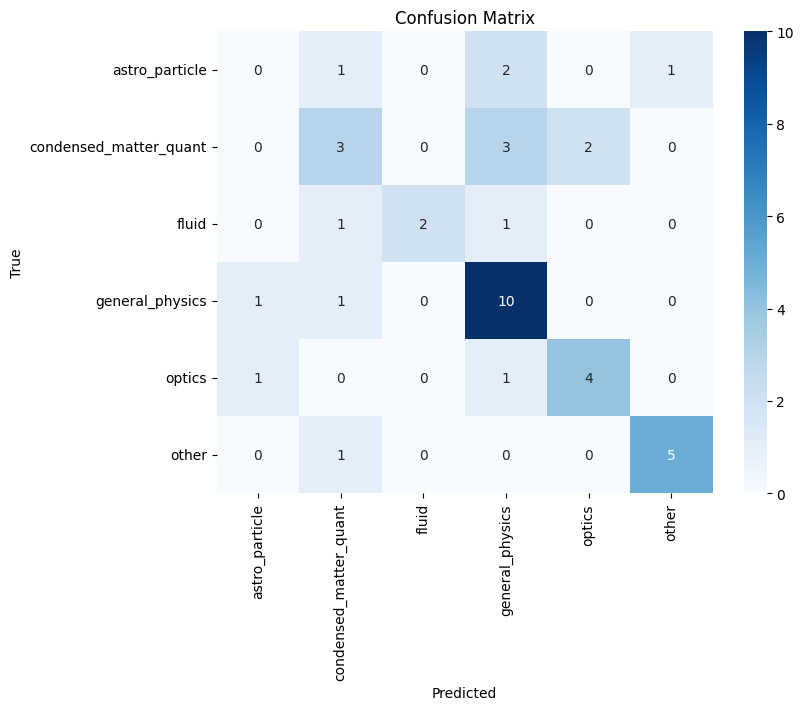

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=range(len(le.classes_)))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [68]:
def show_top_features_per_class(vectorizer_, model_, categories, top_n=10):
    feature_names = np.array(vectorizer_.get_feature_names_out())
    for i, category in enumerate(categories):
        coef = model_.coef_[i]
        top_positive_idx = np.argsort(coef)[-top_n:]
        top_negative_idx = np.argsort(coef)[:top_n]

        print(f"\nCategory: {category}")
        print(f"Top {top_n} positive features:")
        print(feature_names[top_positive_idx][::-1])

        print(f"Top {top_n} negative features:")
        print(feature_names[top_negative_idx])

In [70]:
show_top_features_per_class(vectorizer, log_reg_model, target_categories, top_n=5)


Category: general_physics
Top 5 positive features:
['solar' 'earth' 'clock' 'magnetic' 'shell']
Top 5 negative features:
['quantum' 'systems' 'control' 'state' 'model']

Category: optics
Top 5 positive features:
['quantum' 'photon' 'scaling' 'water' 'atom']
Top 5 negative features:
['energy' 'electron' 'flow' 'solar' 'field']

Category: fluid
Top 5 positive features:
['flow' 'flows' 'fluid' 'turbulent' 'combustion']
Top 5 negative features:
['quantum' 'light' 'energy' 'electron' 'optical']

Category: condensed_matter_quant
Top 5 positive features:
['plasma' 'group' 'elastic' 'textnormal' 'pulmonary']
Top 5 negative features:
['flow' 'phase' 'velocity' 'light' 'water']

Category: other
Top 5 positive features:
['photonic' 'light' 'optical' 'electron' 'laser']
Top 5 negative features:
['flow' 'magnetic' 'water' 'flows' 'solar']

Category: astro_particle
Top 5 positive features:
['reactions' 'models' 'learning' 'electrocatalytic' 'pvg']
Top 5 negative features:
['magnetic' 'field' 'quant

In [84]:

joblib.dump(vectorizer, MODEL_DIR + "/vectorizer.joblib")
joblib.dump(log_reg_model, MODEL_DIR + "/model.joblib")
joblib.dump(le, MODEL_DIR + "/le.joblib")

['/home/frang/arxiv_classifier/models/le.joblib']